# Analyzing data from SUS - São Paulo city

## Read data


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

# Regex
import re

# Plotting
import matplotlib.pyplot as plt

# K-means
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from utils import *

import math
from numpy.random import seed
seed(1)

## Looking for the city of São Paulo

The São Paulo state has the highest number of pacients in bad primary care. To understand how the healthcare system is integrated, we will look for the capital, the city of São Paulo. The data is from 2014 (http://dados.prefeitura.sp.gov.br/dataset/cadastro-dos-estabelecimentos-de-saude).

In [2]:
# Read the health units in the city of São Paulo
hu_sp = pd.read_csv('./cadastro_saude.csv', encoding='ISO-8859-1')
print(hu_sp.columns)
hu_sp

Index(['ID', 'LONG', 'LAT', 'SETCENS', 'AREAP', 'CODDIST', 'DISTRITO',
       'CODSUBPREF', 'SUBPREF', 'REGIAO5', 'REGIAO8', 'ESTABELECI', 'ENDERECO',
       'BAIRRO', 'TELEFONE', 'CEP', 'CNES', 'SA_DEPADM', 'DEPADM', 'SA_TIPO',
       'TIPO', 'SA_CLASSE', 'CLASSE', 'LEITOS'],
      dtype='object')


,ID,LONG,LAT,SETCENS,AREAP,CODDIST,DISTRITO,CODSUBPREF,SUBPREF,REGIAO5,...,TELEFONE,CEP,CNES,SA_DEPADM,DEPADM,SA_TIPO,TIPO,SA_CLASSE,CLASSE,LEITOS
0,1,-46490063,-23522787,355030864000052,3550308005143,65,PONTE RASA,22,ERMELINO MATARAZZO,Leste,...,22800080.0,3680000.0,6393608.000000,1,Municipal,49,AMA ESPECIALIDADES,1,AMBULATORIOS ESPECIALIZADOS,0
1,2,-46773393,-23673297,355030819000016,3550308005232,19,CAPAO REDONDO,17,CAMPO LIMPO,Sul,...,58742846.0,5666000.0,6194974.000000,1,Municipal,49,AMA ESPECIALIDADES,1,AMBULATORIOS ESPECIALIZADOS,0
2,3,-46651898,-23531575,355030869000001,3550308005027,70,SANTA CECILIA,9,SE,Centro,...,38260096.0,1153000.0,6138314.000000,1,Municipal,49,AMA ESPECIALIDADES,1,AMBULATORIOS ESPECIALIZADOS,0
3,4,-46454974,-23538945,355030837000019,3550308005202,36,ITAQUERA,27,ITAQUERA,Leste,...,62860015.0,8210090.0,6394558.000000,1,Municipal,49,AMA ESPECIALIDADES,1,AMBULATORIOS ESPECIALIZADOS,0
4,5,-46539564,-23599363,355030872000050,3550308005158,74,SAO LUCAS,29,VILA PRUDENTE,Leste,...,NaN,3244030.0,6759998.000000,1,Municipal,49,AMA ESPECIALIDADES,1,AMBULATORIOS ESPECIALIZADOS,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462,1464,-46603666,-23555505,355030853000023,3550308005018,54,MOOCA,25,MOOCA,Leste,...,22929512.0,3112090.0,2751917.000000,1,Municipal,17,UNIDADE DE REFERENCIA SAUDE DO IDOSO,1,AMBULATORIOS ESPECIALIZADOS,0
1463,1465,-46709954,-23641851,355030871000035,3550308005174,72,SANTO AMARO,14,SANTO AMARO,Sul,...,55483152.0,4727000.0,6167403.000000,1,Municipal,17,UNIDADE DE REFERENCIA SAUDE DO IDOSO,1,AMBULATORIOS ESPECIALIZADOS,0
1464,1466,-46651898,-23531575,355030869000001,3550308005027,70,SANTA CECILIA,9,SE,Centro,...,38260096.0,1153000.0,2752336.000000,1,Municipal,17,UNIDADE DE REFERENCIA SAUDE DO IDOSO,1,AMBULATORIOS ESPECIALIZADOS,0
1465,1467,-46432853,-23551447,355030837000019,3550308005202,36,ITAQUERA,27,ITAQUERA,Leste,...,NaN,8255010.0,2815478,1,Municipal,44,SUPERVISAO DE VIGILANCIA EM SAUDE,4,VIGILANCIA EM SAUDE,0


In [3]:
hu_sp_classes = hu_sp['CLASSE'].unique()
hu_sp_classes

array(['AMBULATORIOS ESPECIALIZADOS', 'SAUDE MENTAL', 'APOIO DIAGNOSTICO',
       'URGENCIA/EMERGENCIA',
       'OUTROS ESTABELECIMENTOS E SERVICOS ESPECIALIZADOS',
       'VIGILANCIA EM SAUDE', 'UBS/POSTO DE SAUDE/CENTRO DE SAUDE',
       'UNIDADES DST/AIDS', 'HOSPITAL', 'URGENCIA/ EMERGENCIA'],
      dtype=object)

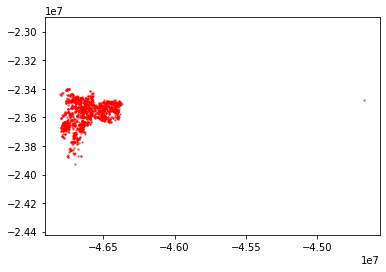

In [4]:
HU_X = 'LONG'
HU_Y = 'LAT'

print_map(hu_sp, show=False, x=HU_X, y=HU_Y, color='red')

As we can see in the map, we have an outlier. To discover what unit it is, we show the healthcare units IDs in the map.

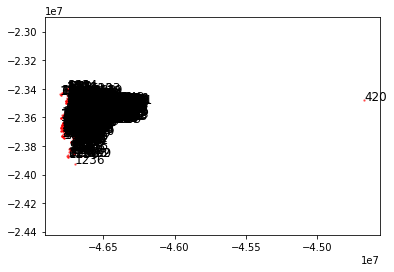

In [5]:
print_map(hu_sp, show=False, x=HU_X, y=HU_Y, color='red')

for i in range(hu_sp.shape[0]):
    hu = hu_sp.iloc[i]
    
    x = hu[HU_X]
    y = hu[HU_Y]
    
    plt.text(x, y, hu['ID'], fontsize=12)
    
plt.show()

The outlier unit is the one with ID 420.

In [6]:
hu_sp[hu_sp['ID'] == 420].values

array([[420, -44671580, -23479782, 355030813000142, 3550308005124, 13,
        'CACHOEIRINHA', 4, 'CASA VERDE-CACHOEIRINHA', 'Norte', 'Norte 1',
        'MARIO DE MORAES ALTENFELDER SILVA,DR,ESC-HOSP MAT',
        'EMILIO CARLOS,DEP,AV,3100', 'V N CACHOEIRINHA', 38594122.0,
        2720200.0, '2079186.000000', 1, 'Municipal', 32,
        'HOSPITAL ESPECIALIZADO', 7, 'HOSPITAL', 176]], dtype=object)

Searching for the 'MARIO DE MORAES ALTENFELDER SILVA,DR,ESC-HOSP MAT', we find that the unit's longitude is wrong. The correct number is `-46670975`. We fix this outlier in the next map and also normalize the geographic data.

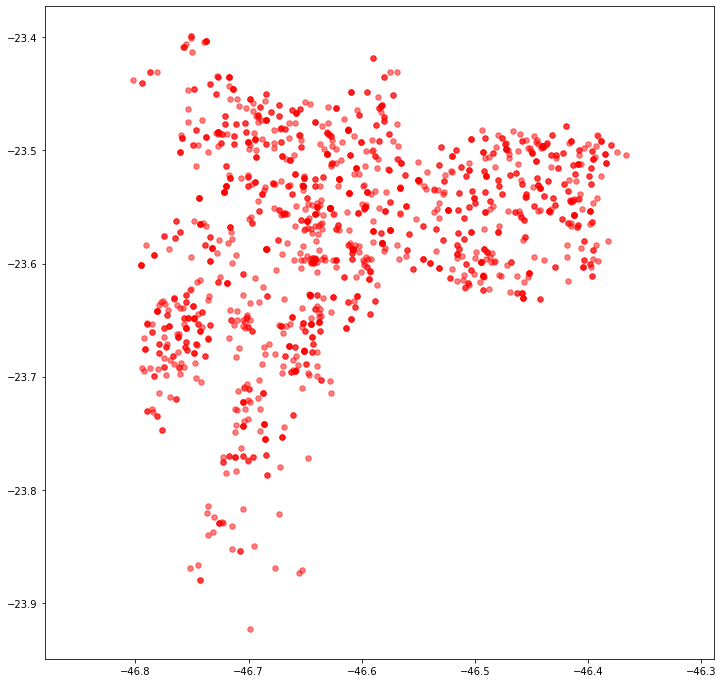

In [7]:
hu_sp.loc[hu_sp['ID'] == 420, HU_X] = -46670975

hu_sp.loc[:, HU_X] = hu_sp[HU_X] / (10**6)
hu_sp.loc[:, HU_Y] = hu_sp[HU_Y] / (10**6)

print_map(hu_sp, x=HU_X, y=HU_Y, color='red', size=30)

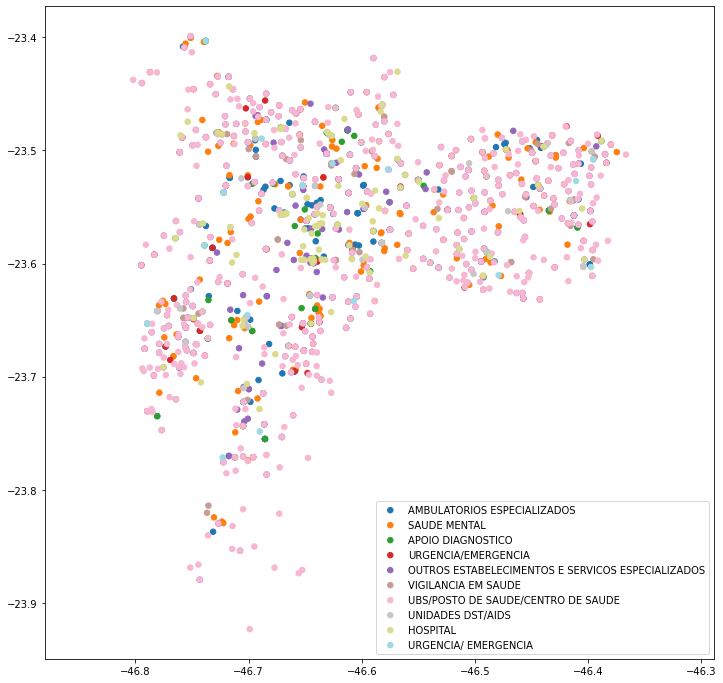

In [8]:
cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1, len(hu_sp_classes)))
color_dict = dict(zip(hu_sp_classes, colors))
index_dict = dict(zip(hu_sp_classes, range(len(hu_sp_classes))))
    
hu_sp.loc[:, 'cor'] = hu_sp['CLASSE'].apply(lambda x: color_dict[x])
hu_sp.loc[:, 'label'] = hu_sp['CLASSE']
hu_sp.loc[:, 'label_prioridade'] = hu_sp['CLASSE'].apply(lambda x: index_dict[x])


figure_size()
print_map(hu_sp, x=HU_X, y=HU_Y, show=False, size=30, alpha=1)

plt.legend()

plt.show()

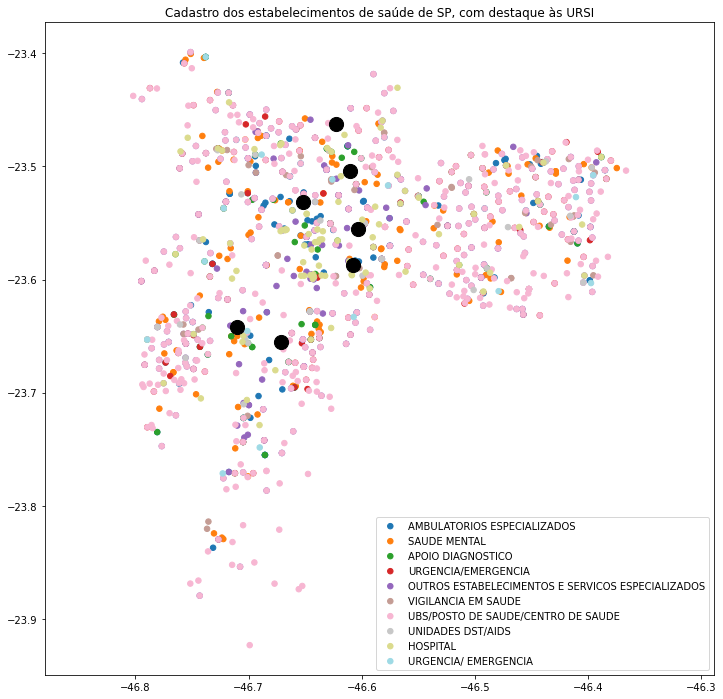

In [9]:
ursi_condition = hu_sp['ESTABELECI'].str.contains('URSI')
ursi = hu_sp[ursi_condition]

figure_size()
print_map(hu_sp, x=HU_X, y=HU_Y, show=False, size=30, alpha=1)

plt.legend()

print_map(ursi, x=HU_X, y=HU_Y, show=False, size=200, alpha=1, color='black')

plt.title('Cadastro dos estabelecimentos de saúde de SP, com destaque às URSI')
# plt.show()

plt.savefig('demo.png', transparent=True)

In [10]:
hu_sp[hu_sp['DISTRITO'].str.contains('LUIS')]

,ID,LONG,LAT,SETCENS,AREAP,CODDIST,DISTRITO,CODSUBPREF,SUBPREF,REGIAO5,...,SA_DEPADM,DEPADM,SA_TIPO,TIPO,SA_CLASSE,CLASSE,LEITOS,cor,label,label_prioridade
7,8,-46.743017,-23.659403,355030846000093,3550308005224,45,JARDIM SAO LUIS,18,M'BOI MIRIM,Sul,...,1,Municipal,49,AMA ESPECIALIDADES,1,AMBULATORIOS ESPECIALIZADOS,0,"[0.12156862745098039, 0.4666666666666667, 0.70...",AMBULATORIOS ESPECIALIZADOS,0
47,48,-46.743017,-23.659403,355030846000093,3550308005224,45,JARDIM SAO LUIS,18,M'BOI MIRIM,Sul,...,1,Municipal,48,APOIO DIAGNOSTICO,2,APOIO DIAGNOSTICO,0,"[0.17254901960784313, 0.6274509803921569, 0.17...",APOIO DIAGNOSTICO,2
55,56,-46.753702,-23.647799,355030846000278,3550308005229,45,JARDIM SAO LUIS,18,M'BOI MIRIM,Sul,...,1,Municipal,4,ASSISTENCIA MEDICA AMBULATORIAL,6,URGENCIA/EMERGENCIA,0,"[0.8392156862745098, 0.15294117647058825, 0.15...",URGENCIA/EMERGENCIA,3
77,78,-46.738671,-23.681333,355030846000056,3550308005222,45,JARDIM SAO LUIS,18,M'BOI MIRIM,Sul,...,1,Municipal,4,ASSISTENCIA MEDICA AMBULATORIAL,6,URGENCIA/EMERGENCIA,0,"[0.8392156862745098, 0.15294117647058825, 0.15...",URGENCIA/EMERGENCIA,3
107,108,-46.743017,-23.659403,355030846000093,3550308005224,45,JARDIM SAO LUIS,18,M'BOI MIRIM,Sul,...,1,Municipal,4,ASSISTENCIA MEDICA AMBULATORIAL,6,URGENCIA/EMERGENCIA,0,"[0.8392156862745098, 0.15294117647058825, 0.15...",URGENCIA/EMERGENCIA,3
131,132,-46.748702,-23.679004,355030846000125,3550308005221,45,JARDIM SAO LUIS,18,M'BOI MIRIM,Sul,...,1,Municipal,4,ASSISTENCIA MEDICA AMBULATORIAL,6,URGENCIA/EMERGENCIA,0,"[0.8392156862745098, 0.15294117647058825, 0.15...",URGENCIA/EMERGENCIA,3
135,136,-46.755453,-23.656634,355030846000224,3550308005229,45,JARDIM SAO LUIS,18,M'BOI MIRIM,Sul,...,1,Municipal,4,ASSISTENCIA MEDICA AMBULATORIAL,6,URGENCIA/EMERGENCIA,0,"[0.8392156862745098, 0.15294117647058825, 0.15...",URGENCIA/EMERGENCIA,3
183,184,-46.746442,-23.701368,355030846000244,3550308005221,45,JARDIM SAO LUIS,18,M'BOI MIRIM,Sul,...,1,Municipal,11,CENTRO DE ATENCAO PSICOSSOCIAL INFANTIL,3,SAUDE MENTAL,0,"[1.0, 0.4980392156862745, 0.054901960784313725...",SAUDE MENTAL,1
298,299,-46.755453,-23.656634,355030846000224,3550308005229,45,JARDIM SAO LUIS,18,M'BOI MIRIM,Sul,...,1,Municipal,24,CENTRO DE ESPECIALIDADES ODONTOLOGICAS/CEO,1,AMBULATORIOS ESPECIALIZADOS,0,"[0.12156862745098039, 0.4666666666666667, 0.70...",AMBULATORIOS ESPECIALIZADOS,0
376,377,-46.736069,-23.666232,355030846000045,3550308005225,45,JARDIM SAO LUIS,18,M'BOI MIRIM,Sul,...,1,Municipal,57,HORA CERTA,1,AMBULATORIOS ESPECIALIZADOS,0,"[0.12156862745098039, 0.4666666666666667, 0.70...",AMBULATORIOS ESPECIALIZADOS,0


In [11]:
hu_sp.median()

ID                  7.350000e+02
LONG               -4.663663e+01
LAT                -2.355906e+01
SETCENS             3.550308e+14
AREAP               3.550308e+12
CODDIST             4.500000e+01
CODSUBPREF          1.700000e+01
TELEFONE            5.588363e+07
CEP                 4.336050e+06
SA_DEPADM           1.000000e+00
SA_TIPO             4.500000e+01
SA_CLASSE           5.000000e+00
LEITOS              0.000000e+00
label_prioridade    4.000000e+00
dtype: float64

In [12]:
sp_groups = hu_sp.groupby('DISTRITO')

for name, group in sp_groups:
    hu_count = group.shape[0]
    beds = group.sum()['LEITOS']
    print('Distrito %s: %d unidades de saúde (%d leitos)' % (name, hu_count, beds))

Distrito AGUA RASA: 10 unidades de saúde (0 leitos)
Distrito ALTO DE PINHEIROS: 5 unidades de saúde (0 leitos)
Distrito ANHANGUERA: 6 unidades de saúde (0 leitos)
Distrito ARICANDUVA: 6 unidades de saúde (0 leitos)
Distrito ARTUR ALVIM: 14 unidades de saúde (0 leitos)
Distrito BARRA FUNDA: 7 unidades de saúde (0 leitos)
Distrito BELA VISTA: 17 unidades de saúde (793 leitos)
Distrito BELEM: 9 unidades de saúde (235 leitos)
Distrito BOM RETIRO: 5 unidades de saúde (0 leitos)
Distrito BRAS: 5 unidades de saúde (0 leitos)
Distrito BRASILANDIA: 29 unidades de saúde (0 leitos)
Distrito BUTANTA: 17 unidades de saúde (257 leitos)
Distrito CACHOEIRINHA: 16 unidades de saúde (359 leitos)
Distrito CAMBUCI: 8 unidades de saúde (14 leitos)
Distrito CAMPO BELO: 4 unidades de saúde (0 leitos)
Distrito CAMPO GRANDE: 7 unidades de saúde (213 leitos)
Distrito CAMPO LIMPO: 27 unidades de saúde (0 leitos)
Distrito CANGAIBA: 12 unidades de saúde (0 leitos)
Distrito CAPAO REDONDO: 30 unidades de saúde (0 le